# Titanic classifier

In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from scipy import stats
np.random.seed(8)

👇 Import the titanic dataset below

In [2]:
data = sns.load_dataset('titanic').drop(columns=['alive'])
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,True


🔥 Your goal is to use SVM classifiers to test if a passenger survived or not (accuracy score), and compare your performance to your buddy of the day on an unseen test set that you will both share. Be aware that you will only have one trial on the test set!

❓ Write down below in pseudo code the different steps your are going to perform to answer the question.

- Check if there are some nan or incoherent values
- Retrieve lines or imput the cells with the right way (average, mode, fix value,...)
- Verify that the dataset is clean
- Check the data types
- Preprocess features from their dtypes
- Create a pipeline
- Add SVC to it
- Fine tune the pipeline
- Fine tune the model

<details><summary>Read our answer suggested answer below</summary>
    
    
1. feature encoding
2. train/test split
3. data cleaning
3. feature scaling
4. model tuning: cross-validated randomsearch (coarse grain first, fine grain after)
5. True performance analysis on test set
</details>

## Encoding

❓ Encode your categorical variables

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(4)
memory usage: 73.7+ KB


In [4]:
le = preprocessing.LabelEncoder()
le.fit(data[["survived"]])
data["survived"] = le.transform(data[["survived"]])
data.head()

/home/antoine/.pyenv/versions/3.8.12/envs/lewagon_current/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,True


In [5]:
data.survived.unique()

array([0, 1])

In [6]:
categorical_features = ["sex", "embarked", "class", "who", "adult_male", "deck", "embark_town", "alone"]
dummies = pd.get_dummies(data[categorical_features])
data = pd.concat([data, dummies], axis=1).drop(columns=categorical_features)
data.head()

,survived,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,...,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton
0,0,3,22.0,1,0,7.2500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


❓ Deal with missing values on your train set as you see fit (do not create data-leaks)

In [7]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   survived                 714 non-null    int64  
 1   pclass                   714 non-null    int64  
 2   age                      714 non-null    float64
 3   sibsp                    714 non-null    int64  
 4   parch                    714 non-null    int64  
 5   fare                     714 non-null    float64
 6   sex_female               714 non-null    uint8  
 7   sex_male                 714 non-null    uint8  
 8   embarked_C               714 non-null    uint8  
 9   embarked_Q               714 non-null    uint8  
 10  embarked_S               714 non-null    uint8  
 11  class_First              714 non-null    uint8  
 12  class_Second             714 non-null    uint8  
 13  class_Third              714 non-null    uint8  
 14  who_child                7

❓ Create X and y

In [8]:
X = data.drop(columns="survived")
y = data["survived"]
print(X.shape)
print(y.shape)

(714, 26)
(714,)


## Holdout

❓ Holdout 30% of your dataset as test set for final evaluation  
(⚠️ use `random_state=0` to compare final results with your buddy)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

## Data cleaning

❓ Scale your training set using the scaler of your choice

In [10]:
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

## Baseline Model

❓ Cross-validate a baseline linear SVC model using the accuracy score. 

In [11]:
%%time
model = SVC(kernel='linear')
cross_val_score(model, X_train_scaled, y_train, cv=5).mean()

CPU times: user 52.1 ms, sys: 0 ns, total: 52.1 ms
Wall time: 46.9 ms


0.8156969696969696

## Random Search

👇 Use a **Random search** to optimize both the parameters `kernel` and `C` of an SVM classifier (SVC), and any other hyperparams of your choice. 
- Start with a total of n_iter=100 combinations, cross-validated 5-time each.
- Use verbose=1 or 2 to check progress
- use n_jobs=-1 to use all your CPU cores

⚠️ If the RandomizedSearchCV seems stuck after more than 10 seconds, make one search per SVM kernel. sklearn sometime experiences issues with grid_searching multiple kernel at a time

In [12]:
model = SVC()

# Hyperparameter search space
search_space = {
    'kernel': ['rbf'],
    'C': stats.uniform(0.01, 100),
    'gamma': stats.loguniform(0.001, 100),
    'degree': stats.randint(1, 5)
}

❓ What are the best parameters and what is the best score?

In [13]:
rsearch = RandomizedSearchCV(model, search_space, n_jobs=-1, scoring='accuracy', cv=5, n_iter=1000, verbose=1)

In [14]:
%%time
rsearch.fit(np.array(X_train_scaled), np.array(y_train))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
CPU times: user 4.22 s, sys: 527 ms, total: 4.75 s
Wall time: 10.1 s


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=1000, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbef48b91c0>,
                                        'degree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbef48b9fa0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbef48b9820>,
                                        'kernel': ['rbf']},
                   scoring='accuracy', verbose=1)

In [15]:
rsearch.best_params_

{'C': 95.37059996818304,
 'degree': 3,
 'gamma': 0.00501523084282083,
 'kernel': 'rbf'}

In [16]:
rsearch.best_score_

0.8256969696969696

## Final test score

Select the best model you want to put to test. You will compare your result with your buddy of the day!

Compute its `accuracy`, `classification_report` and the `confusion_matrix` on the test set.

⚠️ You can only test one model. Once you have seen the test set, any other optimization would result in data-leakage 

In [17]:
model = rsearch.best_estimator_
model.fit(X_train_scaled, y_train)
print(cross_val_score(model, X_train_scaled, y_train, cv=5).mean())

0.8256969696969696


In [18]:
best_model = SVC(C=95.37059996818304, gamma=0.00501523084282083)
best_model.fit(scaler.transform(X_train), y_train)

SVC(C=95.37059996818304, gamma=0.00501523084282083)

In [20]:
y_pred = best_model.predict(scaler.transform(X_test))

In [21]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       125
           1       0.80      0.72      0.76        90

    accuracy                           0.81       215
   macro avg       0.81      0.80      0.80       215
weighted avg       0.81      0.81      0.81       215



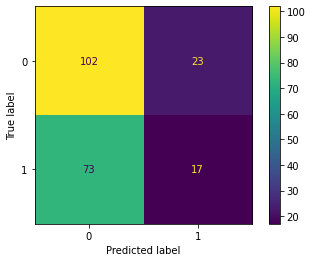

In [23]:
plot_confusion_matrix(model, X_test, y_test)

### To conclude, our model is very good to predict people who has not survived (sensibility 81.6%)
### But is weak concerning the prediction on those who survived (recall 18.9%)

### Actually our accuracy is about 55.3% for the test set

## The preprocessing has to be fine tune, even feature ingineering